**Keras CNN with FastText Embeddings**

CNNs provide a faster alternative to LSTM models at a comparable performance. They are faster to train and use fewer parameters. CNN models are translation invariant and in application to text make sense when there is no strong dependence on recent past vs distant past of the input sequence. CNNs can learn patterns in word embeddings and given the nature of the dataset (e.g. multiple misspellings, out of vocabulary words), it makes sense to use sub-word information. In this notebook, a simple CNN architecture is used for multi-label classification with the help of FastText word embeddings. Thus, it can be a good addition (diverse and accurate) to your ensemble.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

DATA_PATH = '../input/'
EMBEDDING_DIR = '../input/'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


Using TensorFlow backend.


fasttext
jigsaw-toxic-comment-classification-challenge



Let's load the data and the embeddings...

In [2]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

756it [00:00, 7557.00it/s]

loading word embeddings...


111052it [00:13, 7965.87it/s]

found 111052 word vectors


num train:  159571
num test:  153164


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


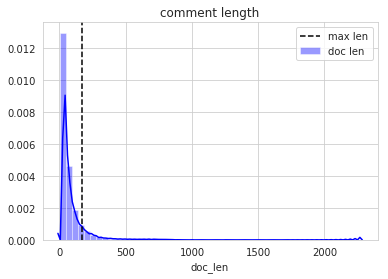

In [3]:
#load data
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge' + '/train.csv', sep=',', header=0)
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge' + '/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

#visualize word distribution
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

Let's pre-process the text, tokenize it and pad it to a maximum length (as in the figure above).

In [4]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  2%|▏         | 3057/159571 [00:00<00:05, 30568.50it/s]

pre-processing train data...


100%|██████████| 153164/153164 [00:04<00:00, 35359.39it/s]


tokenizing input data...
dictionary size:  348520


Let's define our training and model parameters:

In [5]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

We can now prepare our embedding matrix limiting to a max number of words:

In [6]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 47196


It's interesting to look at the words not found in the embeddings:

In [7]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['bunchofgrapes' 'hapy' 'kwilu' 'weant' 'sthenelaos' 'everyon' 'mcsim'
 'kodachrome' 'latibeaudiere' 'thấp']


We can finally define the CNN architecture

In [8]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080

Because of the multi-label loss, we are using k-hot encoding of the output and sigmoid activations. As a result, the loss is binary cross-entropy.

In [9]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [10]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/8
 - 18s - loss: 0.0991 - acc: 0.9692 - val_loss: 0.0668 - val_acc: 0.9779
Epoch 2/8
 - 15s - loss: 0.0658 - acc: 0.9787 - val_loss: 0.0648 - val_acc: 0.9788
Epoch 3/8
 - 15s - loss: 0.0590 - acc: 0.9803 - val_loss: 0.0598 - val_acc: 0.9795
Epoch 4/8
 - 14s - loss: 0.0536 - acc: 0.9815 - val_loss: 0.0582 - val_acc: 0.9799
Epoch 5/8
 - 14s - loss: 0.0492 - acc: 0.9825 - val_loss: 0.0572 - val_acc: 0.9801
Epoch 00005: early stopping


Let's make predictions on the test data:

In [12]:
y_test = model.predict(word_seq_test)

In [ ]:
#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

Looking at training and validation loss / accuracy figures below, we can see there is no sign of over-fitting.

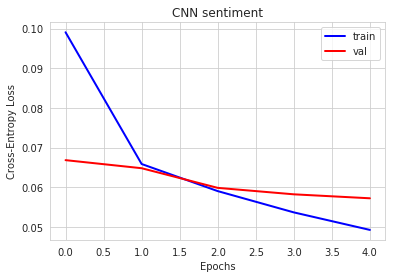

In [13]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

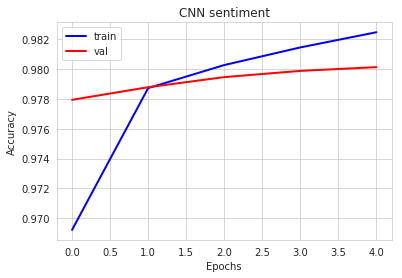

In [14]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**References:**

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016  
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md  
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017  